In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

(512, 512, 512)


Text(0.5, 1.0, 'Lagrangian Density pre re-ion')

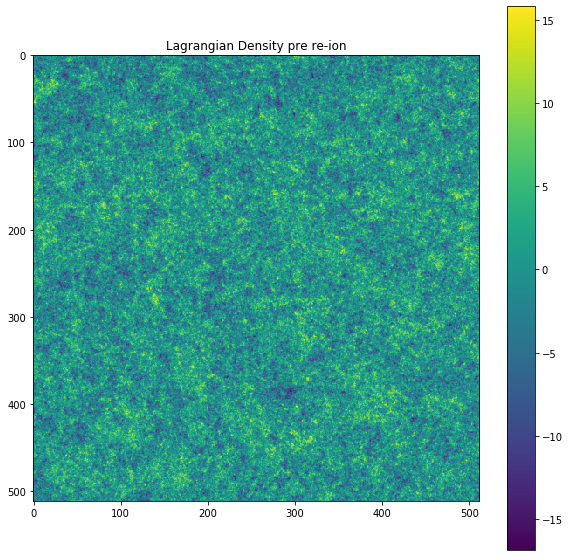

In [2]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'
# datadir = '../multiseed_runs/run0/Boxes/'

freion = open(datadir+'reionization/reion_06')
fdensL  = open(datadir+'density_Lag/dens_06')
fdensE  = open(datadir+'density_Eul/dens_06')

densL = np.fromfile(fdensL, count=N**3, dtype=np.float32).reshape(N,N,N)
densE = np.fromfile(fdensE, count = N**3, dtype=np.float32).reshape(N,N,N)
reion = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


print(densL.shape)
plt.figure(figsize = (10,10))
plt.imshow(densL[0])
plt.colorbar()
plt.title('Lagrangian Density pre re-ion')

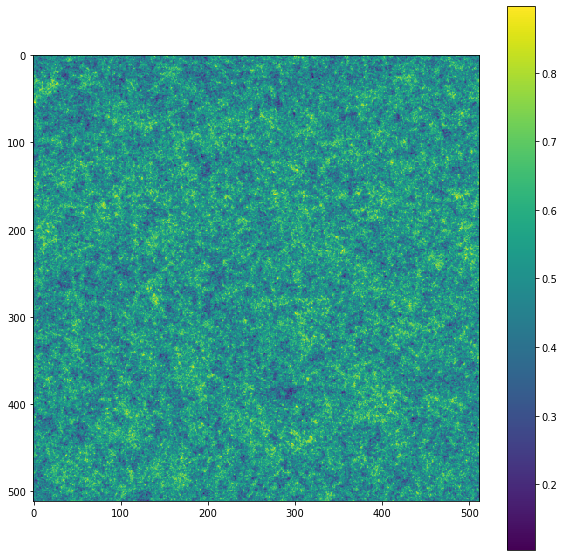

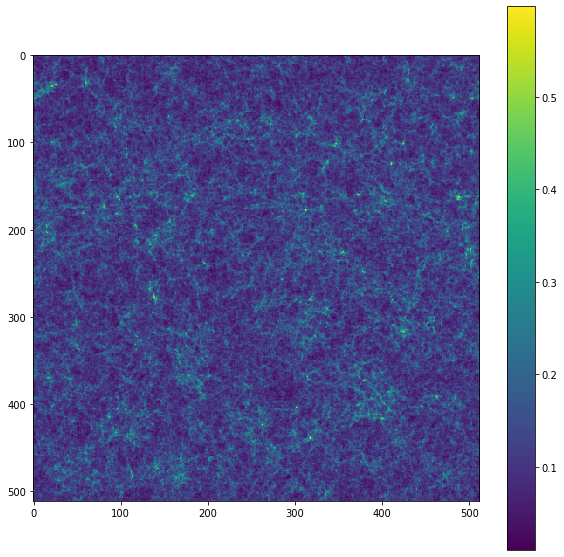

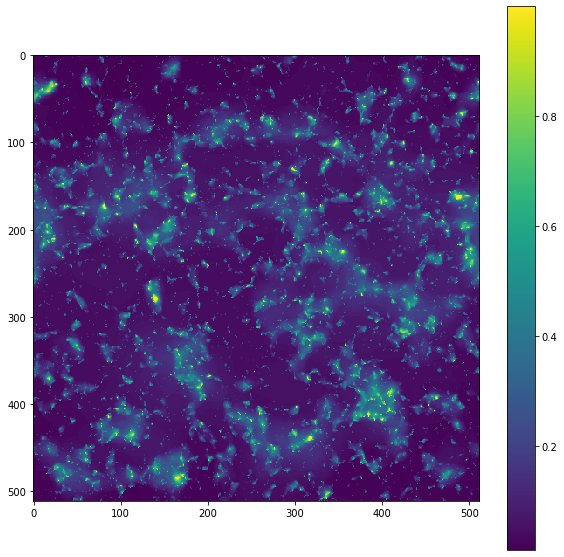

In [4]:
#scaling class for use in the vision linear network to image ionization

class ScaleField():
    # minmax scaling for now
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max()
        self.fmean = field.mean()
    
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin
    
density_scalingL = ScaleField(densL)
density_scalingE = ScaleField(densE)
reionization_scaling = ScaleField(reion)

plt.figure(figsize=(10,10))
plt.imshow(densL[0])
plt.colorbar()

densL = density_scalingL.scale(field=densL, inv=False)
densE = density_scalingE.scale(field=densE, inv=False)
reion = reionization_scaling.scale(field = reion, inv=False)

plt.figure(figsize=(10,10))
plt.imshow(densE[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(reion[0])
plt.colorbar()


In [5]:

def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [ ]:
# def model

# model = tfk.Sequential()

# model.add(tfkl.Conv3D(
#     filters = filters_num, kernel_size = ker, strides=(1, 1, 1), padding='same', 
#     activation='relu',input_shape = (512,512,512,1) ))
# model.add(tfkl.BatchNormalization())

# model.add(tfkl.Conv3D(
#         filters = filters_num,kernel_size = ker, strides=(1, 1, 1), padding='same', 
#         activation='relu',input_shape = (512,512,512,1) ))
# model.add(tfkl.BatchNormalization())




In [6]:
n_filters = 36

img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

model = tfk.Sequential()
    
model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(5,5,5),
                     strides=(1,1,1),
                     use_bias=False,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=False,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=False,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=False,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=1,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=False,padding= 'same'))
model.add(tfkl.Activation('relu'))

model.summary()

#try without bias, vector increase, possible non-use of cube slice pre-process?


## ADD IN A RES NET FACTOR, PLAY AROUND WITH FILTERS AND KERNALS AND NUMBER
## OF LAYERS AS WELL
## LOOK UP HOW TO UPSAMPLE ONCE I DOWNSAMPLE WHICH USES STRIDES GREATER
##GREATER THAN 1
## TRY TO IMPLEMENT SOME SORT OF BAYESIAN NETWORK FACTOR INTO THIS




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 32, 32, 36)    4536      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 36)    35028     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 32, 36)    3

(4096, 32, 32, 32, 1)


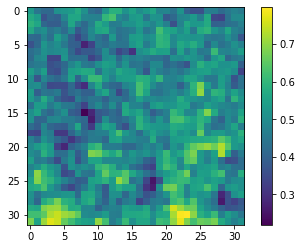

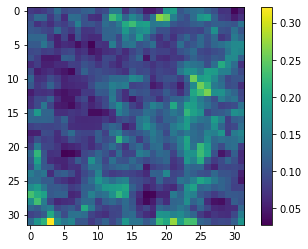

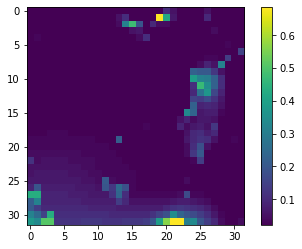

In [7]:
#training data
img_shape = 32

densL_train = cubify(densL,(img_shape,img_shape,img_shape))[..., np.newaxis]
densE_train = cubify(densE,(img_shape,img_shape,img_shape))[..., np.newaxis]
reion_train = cubify(reion,(img_shape,img_shape,img_shape))[..., np.newaxis]

print(reion_train.shape)

plt.figure()
plt.imshow(densL_train[0,0,...,0])
plt.colorbar()

plt.figure()
plt.imshow(densE_train[0,0,...,0])
plt.colorbar()

plt.figure()
plt.imshow(reion_train[0,0,...,0])
plt.colorbar()

Epoch 1/50
116/116 [==============================] - 14s 119ms/step - loss: 0.0149 - mae: 0.0813 - val_loss: 0.0309 - val_mae: 0.1216
Epoch 2/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0058 - mae: 0.0573 - val_loss: 0.0295 - val_mae: 0.1188
Epoch 3/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0048 - mae: 0.0508 - val_loss: 0.0228 - val_mae: 0.0956
Epoch 4/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0044 - mae: 0.0482 - val_loss: 0.0196 - val_mae: 0.0860
Epoch 5/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0041 - mae: 0.0459 - val_loss: 0.0091 - val_mae: 0.0613
Epoch 6/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0040 - mae: 0.0452 - val_loss: 0.0067 - val_mae: 0.0544
Epoch 7/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0037 - mae: 0.0432 - val_loss: 0.0034 - val_mae: 0.0403
Epoch 8/50
116/116 [==============================] - 1

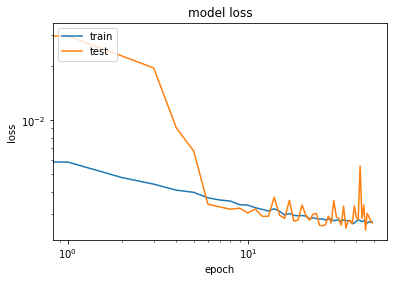

In [8]:
optimizer = tfk.optimizers.Adam(1e-3)
model.compile(optimizer=optimizer, loss="mse", metrics = ['mae'])

history = model.fit(densE_train, reion_train,
               epochs=50, validation_split = 0.1, verbose = 1)

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

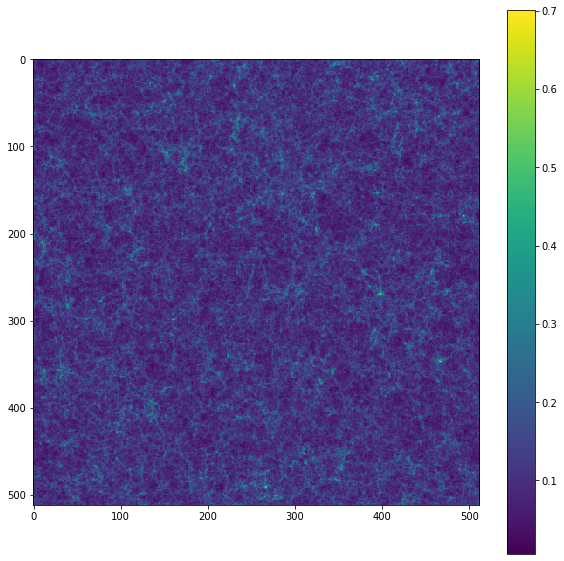

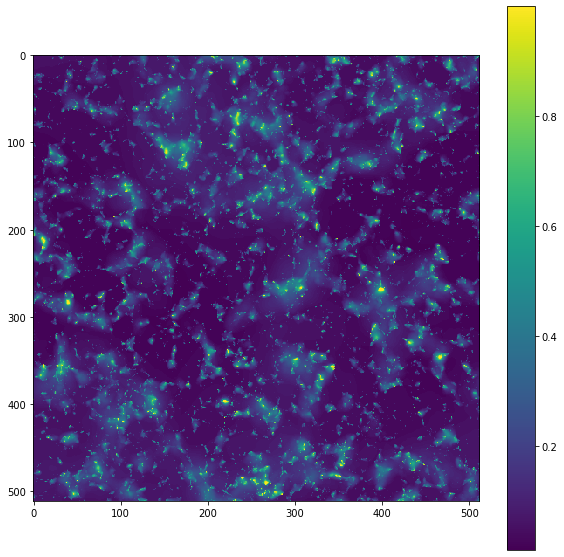

In [9]:
# get test data

datadir = '/global/cscratch1/sd/tmedan/notebooks/'

freion = open(datadir+'reionization/reion_07')
fdens  = open(datadir+'density_Eul/dens_07')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)

density_scaling_test      = ScaleField(x_test)
reionization_scaling_test = ScaleField(y_test)

x_test = density_scaling_test.scale(field=x_test,inv=False)
y_test = reionization_scaling_test.scale(field=y_test,inv=False)

plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]

In [10]:
y_test_predict = model.predict(x_test)

In [11]:
y_test_predict = reionization_scaling_test.scale(field=y_test_predict)

In [12]:
yshow_predict = y_test_predict[0,img_shape//2, ..., 0]
yshow = y_test[0,img_shape//2, ..., 0]

xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

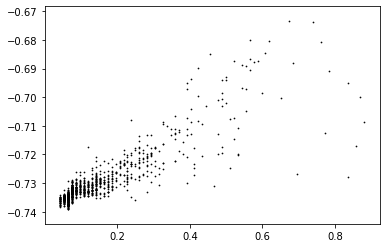

In [13]:
plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)

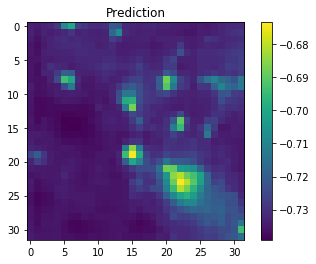

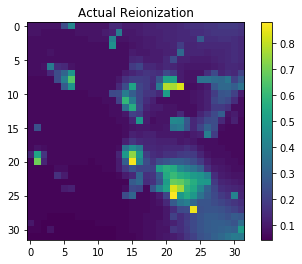

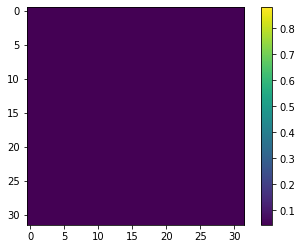

In [14]:
plt.figure()
plt.imshow(yshow_predict)
plt.title('Prediction')
plt.colorbar()



plt.figure()
plt.imshow(yshow)
plt.title('Actual Reionization')
plt.colorbar()



plt.figure()
plt.imshow(yshow_predict,vmin = ymin, vmax = ymax)
plt.colorbar()
